# Exploring the effect of inducer concentration on the noise in gene expression.

In [2]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
import statsmodels.tools.numdiff as smnd # to compute the Hessian matrix

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

### Latex Macros
$\newcommand{\kon}{k_{\text{on}}}$
$\newcommand{\koff}{k_{\text{off}}}$

# Exploring the noise in gene expression.

Fano factor equation
$$
\text{fano-factor} = 1 + {\kon \over (\kon + \koff)}\cdot 
                         {r \over \kon + \koff + \gamma}.
$$

Relationship between $\kon$ and $[R]$.
$$
\kon = [R] \cdot k_o \cdot p_{\text{act}}(c).
$$

In [23]:
def fano_factor(c, Ka, Ki, R, r, gamma, koff, k0=2.7E-3):
    '''
    Computes the fano-factor for mRNA copy number for a simple repression
    inducible system
    Parameters
    ----------
    c : array-like.
        Concentration of inducer.
    Ka, Ki : array-like.
        Dissociation constants of the inducer to the active and inactive 
        repressor respectively.
    R : array-like.
        Repressor copy number per cell.
    r : array-like
        mRNA production rate.
    gamma : array-like.
        mRNA degradation rate.
    koff : array-like.
        rate constant of repressor falling off the DNA.
    k0 : array-like 
        proportionality constant for repressor concentration and kon.
    
    Returns
    -------
    Fano factor
    '''
    # Compute pactive given the inducer concentration and the dissociation
    # constants
    pact = mwc.pact_log(iptg=c, ea=-np.log(Ka), ei=-np.log(Ki))
    
    R_conc = 1.66 * R # Convert to concentration
    
    # Calculate the kon rate constant based on R and pactive
    kon = R_conc * k0 * pact
    
    # Compute and return the fano factor
    return 1 + kon / (kon + koff) * r / (kon + koff + gamma)

Define relevant parameters to evaluate

In [49]:
Ka = 139 # µM
Ki = 0.53 # µM
# gamma = 0.00284 
gamma = 1/(3 * 60)
r = 15.7 * gamma

operators = ['O1', 'O2', 'O3', 'Oid']
koff = {'O1' : 0.0069, 'O2' : 0.091, 'O3' : 2.1, 'Oid' : 0.0023}
R = np.array([22, 60, 124, 260, 1220, 1740])[::-1]

# Plot the theory vs data for the titration curves
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 200)
IPTG_lin = np.array([0, 1E-7])

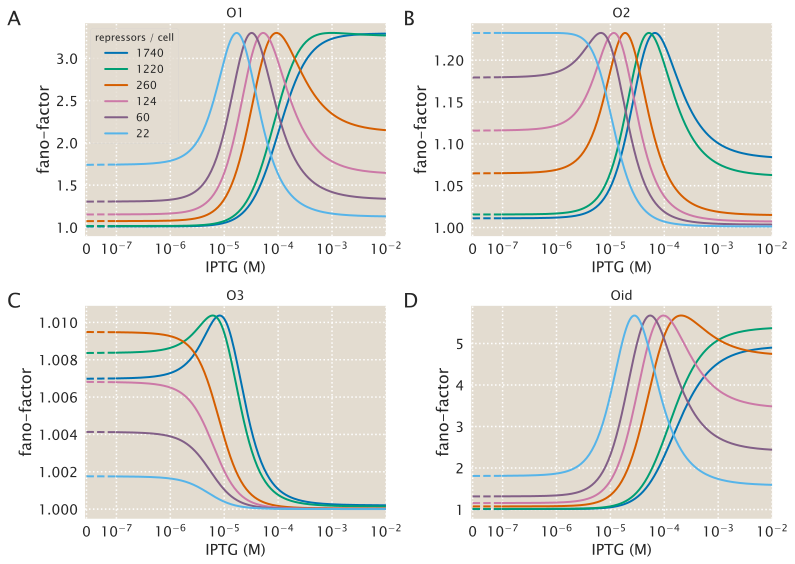

In [50]:
# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Initialize the plot to set the size
fig, ax = plt.subplots(2, 2, figsize=(11, 8), sharey=False)
ax = ax.ravel()

# Loop through operators
for i, op in enumerate(operators):
    # loop through RBS mutants
    for j, rep in enumerate(R):
        # plot the theory using the parameters from the fit.
        # Log scale
        ax[i].plot(IPTG, fano_factor(IPTG * 1E6, 
            Ka=Ka, Ki=Ki, R=rep, r=r, gamma=gamma, koff=koff[op]),
            color=colors[j], label=str(rep))
        # Linear scale
        ax[i].plot(IPTG_lin, fano_factor(IPTG_lin * 1E6, 
            Ka=Ka, Ki=Ki, R=rep, r=r, gamma=gamma, koff=koff[op]),
            color=colors[j], linestyle='--', label='')
            

    # Add operator and binding energy labels.
    ax[i].set_title(op, fontsize=13)
    ax[i].set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fano-factor', fontsize=16)
    ax[i].set_xlim([-5E-9, 1E-2])
    ax[i].tick_params(labelsize=14)

ax[0].legend(loc='upper left', title='repressors / cell', fontsize=11)
# # add plot letter labels
plt.figtext(0.0, .95, 'A', fontsize=20)
plt.figtext(0.50, .95, 'B', fontsize=20)
plt.figtext(0.0, .46, 'C', fontsize=20)
plt.figtext(0.50, .46, 'D', fontsize=20)
plt.tight_layout()
plt.savefig('/Users/razo/Dropbox/mwc_induction/resubmission figures/fano.pdf')

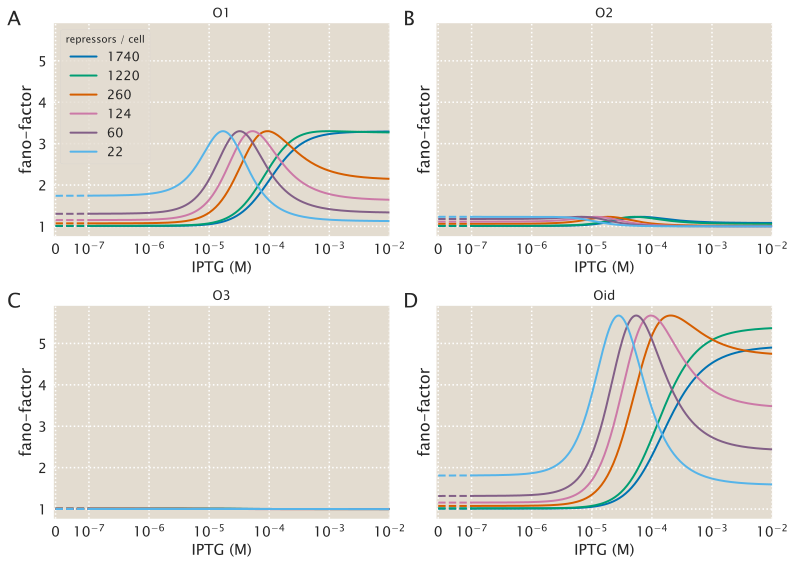

In [51]:
# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Initialize the plot to set the size
fig, ax = plt.subplots(2, 2, figsize=(11, 8), sharey=True)
ax = ax.ravel()

# Loop through operators
for i, op in enumerate(operators):
    # loop through RBS mutants
    for j, rep in enumerate(R):
        # plot the theory using the parameters from the fit.
        # Log scale
        ax[i].plot(IPTG, fano_factor(IPTG * 1E6, 
            Ka=Ka, Ki=Ki, R=rep, r=r, gamma=gamma, koff=koff[op]),
            color=colors[j], label=str(rep))
        # Linear scale
        ax[i].plot(IPTG_lin, fano_factor(IPTG_lin * 1E6, 
            Ka=Ka, Ki=Ki, R=rep, r=r, gamma=gamma, koff=koff[op]),
            color=colors[j], linestyle='--', label='')
            

    # Add operator and binding energy labels.
    ax[i].set_title(op, fontsize=13)
    ax[i].set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fano-factor', fontsize=16)
    ax[i].set_xlim([-5E-9, 1E-2])
    ax[i].tick_params(labelsize=14)

ax[0].legend(loc='upper left', title='repressors / cell')
# # add plot letter labels
plt.figtext(0.0, .95, 'A', fontsize=20)
plt.figtext(0.50, .95, 'B', fontsize=20)
plt.figtext(0.0, .46, 'C', fontsize=20)
plt.figtext(0.50, .46, 'D', fontsize=20)
plt.tight_layout()
plt.savefig('/Users/razo/Dropbox/mwc_induction/resubmission figures/fano_scale.pdf')

# Looking at the variance only

In [40]:
def var_mRNA(c, Ka, Ki, R, r, gamma, koff, k0=2.7E-3):
    '''
    Computes the fano-factor for mRNA copy number for a simple repression
    inducible system
    Parameters
    ----------
    c : array-like.
        Concentration of inducer.
    Ka, Ki : array-like.
        Dissociation constants of the inducer to the active and inactive 
        repressor respectively.
    R : array-like.
        Repressor copy number per cell.
    r : array-like
        mRNA production rate.
    gamma : array-like.
        mRNA degradation rate.
    koff : array-like.
        rate constant of repressor falling off the DNA.
    k0 : array-like 
        proportionality constant for repressor concentration and kon.
    
    Returns
    -------
    Fano factor
    '''
    # Compute pactive given the inducer concentration and the dissociation
    # constants
    pact = mwc.pact_log(iptg=c, ea=-np.log(Ka), ei=-np.log(Ki))
    
    R_conc = 1.66 * R # Convert to concentration
    
    # Calculate the kon rate constant based on R and pactive
    kon = R_conc * k0 * pact
    
    # Compute and return the fano factor
    fano = 1 + kon / (kon + koff) * r / (kon + koff + gamma)
    mean = r / gamma * kon / (kon + koff)
    
    return fano * mean

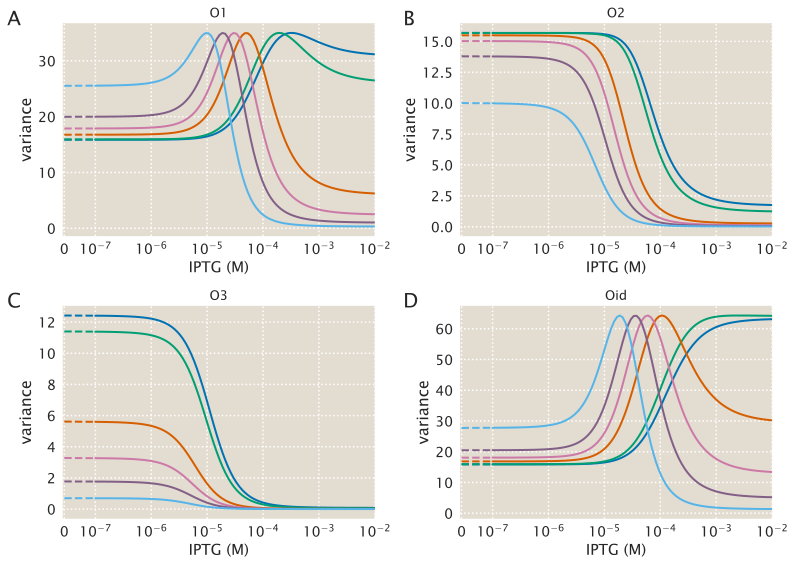

In [43]:
# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Initialize the plot to set the size
fig, ax = plt.subplots(2, 2, figsize=(11, 8), sharey=False)
ax = ax.ravel()

# Loop through operators
for i, op in enumerate(operators):
    # loop through RBS mutants
    for j, rep in enumerate(R):
        # plot the theory using the parameters from the fit.
        # Log scale
        ax[i].plot(IPTG, var_mRNA(IPTG * 1E6, 
            Ka=Ka, Ki=Ki, R=rep, r=r, gamma=gamma, koff=koff[op]),
            color=colors[j])
        # Linear scale
        ax[i].plot(IPTG_lin, var_mRNA(IPTG_lin * 1E6, 
            Ka=Ka, Ki=Ki, R=rep, r=r, gamma=gamma, koff=koff[op]),
            color=colors[j], linestyle='--')
            

    # Add operator and binding energy labels.
    ax[i].set_title(op, fontsize=13)
    ax[i].set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('variance', fontsize=16)
    ax[i].set_xlim([-5E-9, 1E-2])
    ax[i].tick_params(labelsize=14)

# ax[0].legend(loc='upper left', title='repressors / cell')
# # add plot letter labels
plt.figtext(0.0, .95, 'A', fontsize=20)
plt.figtext(0.50, .95, 'B', fontsize=20)
plt.figtext(0.0, .46, 'C', fontsize=20)
plt.figtext(0.50, .46, 'D', fontsize=20)
plt.tight_layout()
# plt.savefig('/Users/razo/Dropbox/mwc_induction/resubmission figures/fano.pdf')